# Network Embedding via Random Walks

## Import modules and Data

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from matplotlib import pyplot as plt 
np.random.seed(15)

In [2]:
#Load data
adjlist = nx.read_adjlist("karate_club.adjlist", nodetype=int)
#karate_label = np.loadtxt("karate_label.txt")

In [3]:
adj = nx.to_numpy_array(adjlist)
#label = karate_label[:,-1]

print(adj.shape)
#print(label.shape)

(34, 34)


## Nerual Network class
+ used softmax function instead of sigmoid when feed_forward
+ unlike 2-nn we made, deleted activation after hidden layer (after passing W1) sin ce its from word2back network 

+ backpropagation process is simliar to ass 2

In [15]:
#actiavtion function 
def softmax(x):
    c = np.max(x)
    b = x-c
    exp_x = np.exp(b)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

In [16]:
#fully conneted network
class ann:
    def __init__(self, input_size, hidden_size,output_size):
        #setting the shape of the layer and putting random inital value 
        self.params = {}
        self.params['W1'] = np.random.randn(input_size,hidden_size)
        self.params['W2'] = np.random.randn(hidden_size,output_size)
    
    #Calculating the Values
    def gradient(self, x, y):
        
        #forward
        W1,W2 = self.params['W1'],self.params['W2']
        H = np.dot(x,W1)
        #H = softmax(U)
        
        U2 = np.dot(H,W2)
        Y = softmax(U2)
        
        #backpropagation
        
        ERR2 = (Y-y)*Y*(1-Y)
        ERR = np.dot((ERR2 * W2),np.dot(H,1-H))

        return ERR,ERR2,H,Y
        

## initializing variable and params

In [6]:
w = 3 #window_size w
d = 2 #embedding size d
r = 10 # walks per vertex
t = 10 # walk length
learning_rate = 0.01

In [7]:
#Params
n_network = ann(input_size = 34,hidden_size = d,output_size = 34)
#P = np.random.random((34,d)) # Work as W1 (input_size,hidden_size)
#Q = np.random.random((d,34)) # work as W2 (hidden_size, input_size)

## Main Function
+ random_walk ( find near vertexs and choose )
+ skipgram (make windows depending on window size)
+ updated params in skipgram

In [9]:
def random_walk(vertex,t):
    ans = []
    ans.append(vertex)
    
    while True:
        #stop untill the window size get t
        if len(ans) == t:
            return ans
            
        #check nearest vertexs
        vertex_adj_list = list(adj[vertex]) 
        near_vertex_index = np.nonzero(vertex_adj_list)
    
        #choose the nearess vertex randomly
        get_vertex = np.random.choice(list(near_vertex_index[0]),1)
        ans.append(get_vertex[0])
        vertex = get_vertex[0]


In [10]:
def skipgram(W,w,loss):
    for idx, vertex in enumerate(W):
        
        #making u_list considering w
        start = idx-w
        end = idx+w
        if start < 0:
            start = 0
        if end >= len(W):
            end = len(W)-1

        u_list = []
        u_list.extend(W[start:idx])
        u_list.extend(W[idx+1:end+1])
        
        #calculating each u from u_list
        for each_u in u_list:
            
            # input, ouput with one-hot encoding
            input_vertex = np.zeros(34)
            y_pred = np.zeros(34)
            v = vertex
            u = each_u
            input_vertex[v] = 1
            y_pred[u] = 1
            
            #gradient (forward,backpropa)
            
            ERR,ERR2,H,Y = n_network.gradient(input_vertex,y_pred)
            
            #updata params
            n_network.params['W1'] -= (learning_rate * ERR * input_vertex).T
            n_network.params['W2'] -= learning_rate *np.outer(H, ERR2)
            #n_network.params['W2'] -= np.reshape(learning_rate * ERR2 * H.T, (d,34))
            
            #calculating loss
    
            loss[v] -= np.log(np.mean(np.abs(y_pred-Y)))
            loss[v] = loss[v]
    return loss

In [11]:
epoch = 30
epoch_loss = []
epoch_loss2 = []
for _ in range(epoch):
    for i in range(r):
        O = np.arange(34)
        np.random.shuffle(O)
    
        for vertex in O:
            W = random_walk(vertex,t)
            loss = [0 for _ in range(34)]
            loss = skipgram(W,w,loss)
            epoch_loss.append(loss)
    epoch_loss2.append(np.mean(loss))
    #calculating loss
    #n_networ.params['W1']    

In [13]:
epoch_loss= np.sum(np.array(epoch_loss),axis = 1)

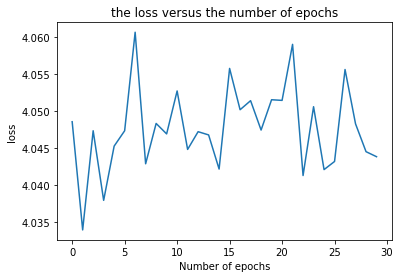

In [14]:
from matplotlib import pyplot as plt
plt.plot(epoch_loss2)
plt.title("the loss versus the number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("loss")
plt.show()

## Plotting in 2-dim with TSNE

+ it seems that nearest vertexs have "1"s in adj matrix
+ but there are many wrong ones (which means some are faraway eventhough they have"1"
+ it will probably improved when hidden layer (which is d) get higher
+ Erased labels since didnt need at all

In [18]:
nums = np.identity(34)
W1 = n_network.params['W1']
output = np.dot(nums , W1)

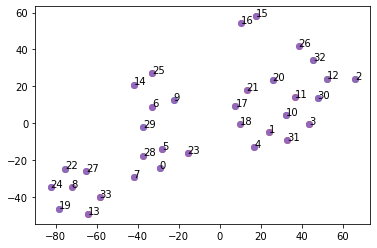

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100,perplexity=8)
transformed = model.fit_transform(output)
xs = transformed[:,0]
ys = transformed[:,1]

for i in range(len(xs)):
    plt.scatter(xs[i],ys[i])
    plt.text(xs[i],ys[i],i)
plt.scatter(xs,ys)
#plt.text(xs,ys)

plt.show()